In [1]:
from pathlib import Path
from collections import defaultdict
from pandas import DataFrame

data = defaultdict(list)
for script in Path().glob("../*/*.sh"):
    name = script.name.split(".")[0]
    log = script.with_name(f"{name}.log")
    if not log.exists():
        continue

    nbatches, tooks = 0, []
    for line in log.read_text().splitlines():
        if "took" in line:
            tooks.append(float(line.split()[11]))
        if "Doing" in line and "batches" in line:
            nbatches = int(line.split()[8])
    if len(tooks) < 3:
        continue
    # print(tooks, nbatches)
    took_once_1st, took_all, took_once_2nd = tooks

    nnodes, ncpus = 1, 28
    for line in script.read_text().splitlines():
        if line.startswith("#SBATCH"):
            content = line.split()[1]
            if content.startswith("--nodes"):
                nnodes = int(content.split("=")[1])
            elif content.startswith("--cpus-per-task"):
                ncpus = int(content.split("=")[1])
        if line.startswith("python"):
            nbatches2 = int(line.split()[2])
            assert nbatches == nbatches2

    data["dir_name"].append(script.parent.name)
    data["job_name"].append(name)
    data["key"].append(f"{nnodes}n{ncpus:02d}c")
    data["took_once_1st"].append(took_once_1st)
    data["took_once_2nd"].append(took_once_2nd)
    data["took_all"].append(took_all)
    data["nbatches"].append(nbatches)
    data["nnodes"].append(nnodes)
    data["ncpus"].append(ncpus)

data = DataFrame(data)
data["batch-per-cpu"] = data["nbatches"] / data["ncpus"] / data["nnodes"]
data.to_csv("data-log-sh.csv", index=False)
data

,dir_name,job_name,key,took_once_1st,took_once_2nd,took_all,nbatches,nnodes,ncpus,batch-per-cpu
0,test_nodes-2,3n28c_0929-1626,3n28c,4.34,0.19,507.65,210000,3,28,2500.0
1,test_nodes-2,2n28c_0929-1606,2n28c,4.37,0.19,464.62,140000,2,28,2500.0
2,test_nodes,2n08c_0929-1611,2n08c,60.58,0.20,833.60,40000,2,8,2500.0
3,test_nodes,2n14c_0929-1612,2n14c,44.37,0.21,808.30,70000,2,14,2500.0
4,test_nodes,2n2c_0929-1604,2n02c,101.27,0.20,831.84,10000,2,2,2500.0
5,test_nodes,3n28c_0929-1626,3n28c,53.63,0.20,1327.89,210000,3,28,2500.0
6,test_nodes,2n28c_0929-1606,2n28c,21.35,0.19,482.06,140000,2,28,2500.0
7,test_nodes-3,test-ray-2n_0929-1429-copy,2n28c,18.09,0.19,1375.13,420000,2,28,7500.0
8,test_nodes-3,test-ray-4n_0929-1429,4n28c,5.59,0.24,1449.89,840000,4,28,7500.0
9,test_nodes-3,test-ray-2n_0929-1429,2n28c,57.85,0.17,2617.99,420000,2,28,7500.0


In [2]:
import pandas as pd

data_slurm = pd.read_csv("data-slurm.csv")
data_slurm

,job_name,key,batch-per-cpu,core*s,cpu%
0,3n28c_0929-1626,3n28c,2500.0,46956,40.25
1,2n28c_0929-1606,2n28c,2500.0,28616,49.59
2,2n08c_0929-1611,2n08c,2500.0,15024,43.90
3,2n14c_0929-1612,2n14c,2500.0,25116,29.44
4,2n2c_0929-1604,2n02c,2500.0,3912,42.54
5,3n28c_0929-1626,3n28c,2500.0,120456,25.03
6,2n28c_0929-1606,2n28c,2500.0,30576,41.25
7,test-ray-2n_0929-1429-copy,2n28c,7500.0,80528,74.73
8,test-ray-4n_0929-1429,4n28c,7500.0,169232,73.72
9,test-ray-2n_0929-1429,2n28c,7500.0,152880,46.22


In [3]:
import numpy as np

assert (data_slurm["job_name"] == data["job_name"]).all()
df = data.copy()
for k in data_slurm.columns[3:]:
    df[k] = data_slurm[k].astype(float)  # type: ignore
df["real_time(min)"] = df["core*s"] / df["ncpus"] / df["nnodes"] / 60
df["ray_time(min)"] = df["took_all"] / 60
df["serial_time(min)"] = df["took_once_2nd"].min() / 60 * df["nbatches"]
df["ncore"] = df["ncpus"] * df["nnodes"]
df = df.sort_values(["dir_name", "key"], ignore_index=True)


df = df[np.logical_or(df["ncpus"] == 28, df["nnodes"] == 1)]
df["speed-up(ray)"] = df["serial_time(min)"] / df["ray_time(min)"]
df["speed-up(real)"] = df["serial_time(min)"] / df["real_time(min)"]
df["real%"] = df["speed-up(real)"] / df["ncore"] * 100
df["ray%"] = df["speed-up(ray)"] / df["ncore"] * 100
df.to_csv("data.csv", index=False)
df

,dir_name,job_name,key,took_once_1st,took_once_2nd,took_all,nbatches,nnodes,ncpus,batch-per-cpu,core*s,cpu%,real_time(min),ray_time(min),serial_time(min),ncore,speed-up(ray),speed-up(real),real%,ray%
3,test_nodes,2n28c_0929-1606,2n28c,21.35,0.19,482.06,140000,2,28,2500.0,30576.0,41.25,9.100000,8.034333,396.666667,56,49.371448,43.589744,77.838828,88.163299
4,test_nodes,3n28c_0929-1626,3n28c,53.63,0.20,1327.89,210000,3,28,2500.0,120456.0,25.03,23.900000,22.131500,595.000000,84,26.884757,24.895397,29.637378,32.005663
5,test_nodes-2,2n28c_0929-1606,2n28c,4.37,0.19,464.62,140000,2,28,2500.0,28616.0,49.59,8.516667,7.743667,396.666667,56,51.224657,46.575342,83.170254,91.472601
6,test_nodes-2,3n28c_0929-1626,3n28c,4.34,0.19,507.65,210000,3,28,2500.0,46956.0,40.25,9.316667,8.460833,595.000000,84,70.324042,63.864043,76.028623,83.719098
7,test_nodes-3,test-ray-2n_0929-1429-copy,2n28c,18.09,0.19,1375.13,420000,2,28,7500.0,80528.0,74.73,23.966667,22.918833,1190.000000,56,51.922364,49.652295,88.664812,92.718507
8,test_nodes-3,test-ray-2n_0929-1429,2n28c,57.85,0.17,2617.99,420000,2,28,7500.0,152880.0,46.22,45.500000,43.633167,1190.000000,56,27.272831,26.153846,46.703297,48.701485
9,test_nodes-3,test-ray-4n_0929-1429,4n28c,5.59,0.24,1449.89,840000,4,28,7500.0,169232.0,73.72,25.183333,24.164833,2380.000000,112,98.490230,94.506949,84.381205,87.937706
10,test_once,test-ray-4c_0929-1426,1n04c,76.23,0.18,1351.59,30000,1,4,7500.0,5896.0,73.71,24.566667,22.526500,85.000000,4,3.773334,3.459973,86.499322,94.333341
11,test_once,test-ray-8c_0929-1426,1n08c,51.40,0.18,1283.21,60000,1,8,7500.0,11040.0,80.99,23.000000,21.386833,170.000000,8,7.948816,7.391304,92.391304,99.360198
12,test_once,test-ray-16c_0929-1427,1n16c,5.20,0.18,1215.82,120000,1,16,7500.0,20128.0,92.74,20.966667,20.263667,340.000000,16,16.778799,16.216216,101.351351,104.867497


In [4]:
df.sort_values("key", ignore_index=True)
df


,dir_name,job_name,key,took_once_1st,took_once_2nd,took_all,nbatches,nnodes,ncpus,batch-per-cpu,core*s,cpu%,real_time(min),ray_time(min),serial_time(min),ncore,speed-up(ray),speed-up(real),real%,ray%
3,test_nodes,2n28c_0929-1606,2n28c,21.35,0.19,482.06,140000,2,28,2500.0,30576.0,41.25,9.100000,8.034333,396.666667,56,49.371448,43.589744,77.838828,88.163299
4,test_nodes,3n28c_0929-1626,3n28c,53.63,0.20,1327.89,210000,3,28,2500.0,120456.0,25.03,23.900000,22.131500,595.000000,84,26.884757,24.895397,29.637378,32.005663
5,test_nodes-2,2n28c_0929-1606,2n28c,4.37,0.19,464.62,140000,2,28,2500.0,28616.0,49.59,8.516667,7.743667,396.666667,56,51.224657,46.575342,83.170254,91.472601
6,test_nodes-2,3n28c_0929-1626,3n28c,4.34,0.19,507.65,210000,3,28,2500.0,46956.0,40.25,9.316667,8.460833,595.000000,84,70.324042,63.864043,76.028623,83.719098
7,test_nodes-3,test-ray-2n_0929-1429-copy,2n28c,18.09,0.19,1375.13,420000,2,28,7500.0,80528.0,74.73,23.966667,22.918833,1190.000000,56,51.922364,49.652295,88.664812,92.718507
8,test_nodes-3,test-ray-2n_0929-1429,2n28c,57.85,0.17,2617.99,420000,2,28,7500.0,152880.0,46.22,45.500000,43.633167,1190.000000,56,27.272831,26.153846,46.703297,48.701485
9,test_nodes-3,test-ray-4n_0929-1429,4n28c,5.59,0.24,1449.89,840000,4,28,7500.0,169232.0,73.72,25.183333,24.164833,2380.000000,112,98.490230,94.506949,84.381205,87.937706
10,test_once,test-ray-4c_0929-1426,1n04c,76.23,0.18,1351.59,30000,1,4,7500.0,5896.0,73.71,24.566667,22.526500,85.000000,4,3.773334,3.459973,86.499322,94.333341
11,test_once,test-ray-8c_0929-1426,1n08c,51.40,0.18,1283.21,60000,1,8,7500.0,11040.0,80.99,23.000000,21.386833,170.000000,8,7.948816,7.391304,92.391304,99.360198
12,test_once,test-ray-16c_0929-1427,1n16c,5.20,0.18,1215.82,120000,1,16,7500.0,20128.0,92.74,20.966667,20.263667,340.000000,16,16.778799,16.216216,101.351351,104.867497


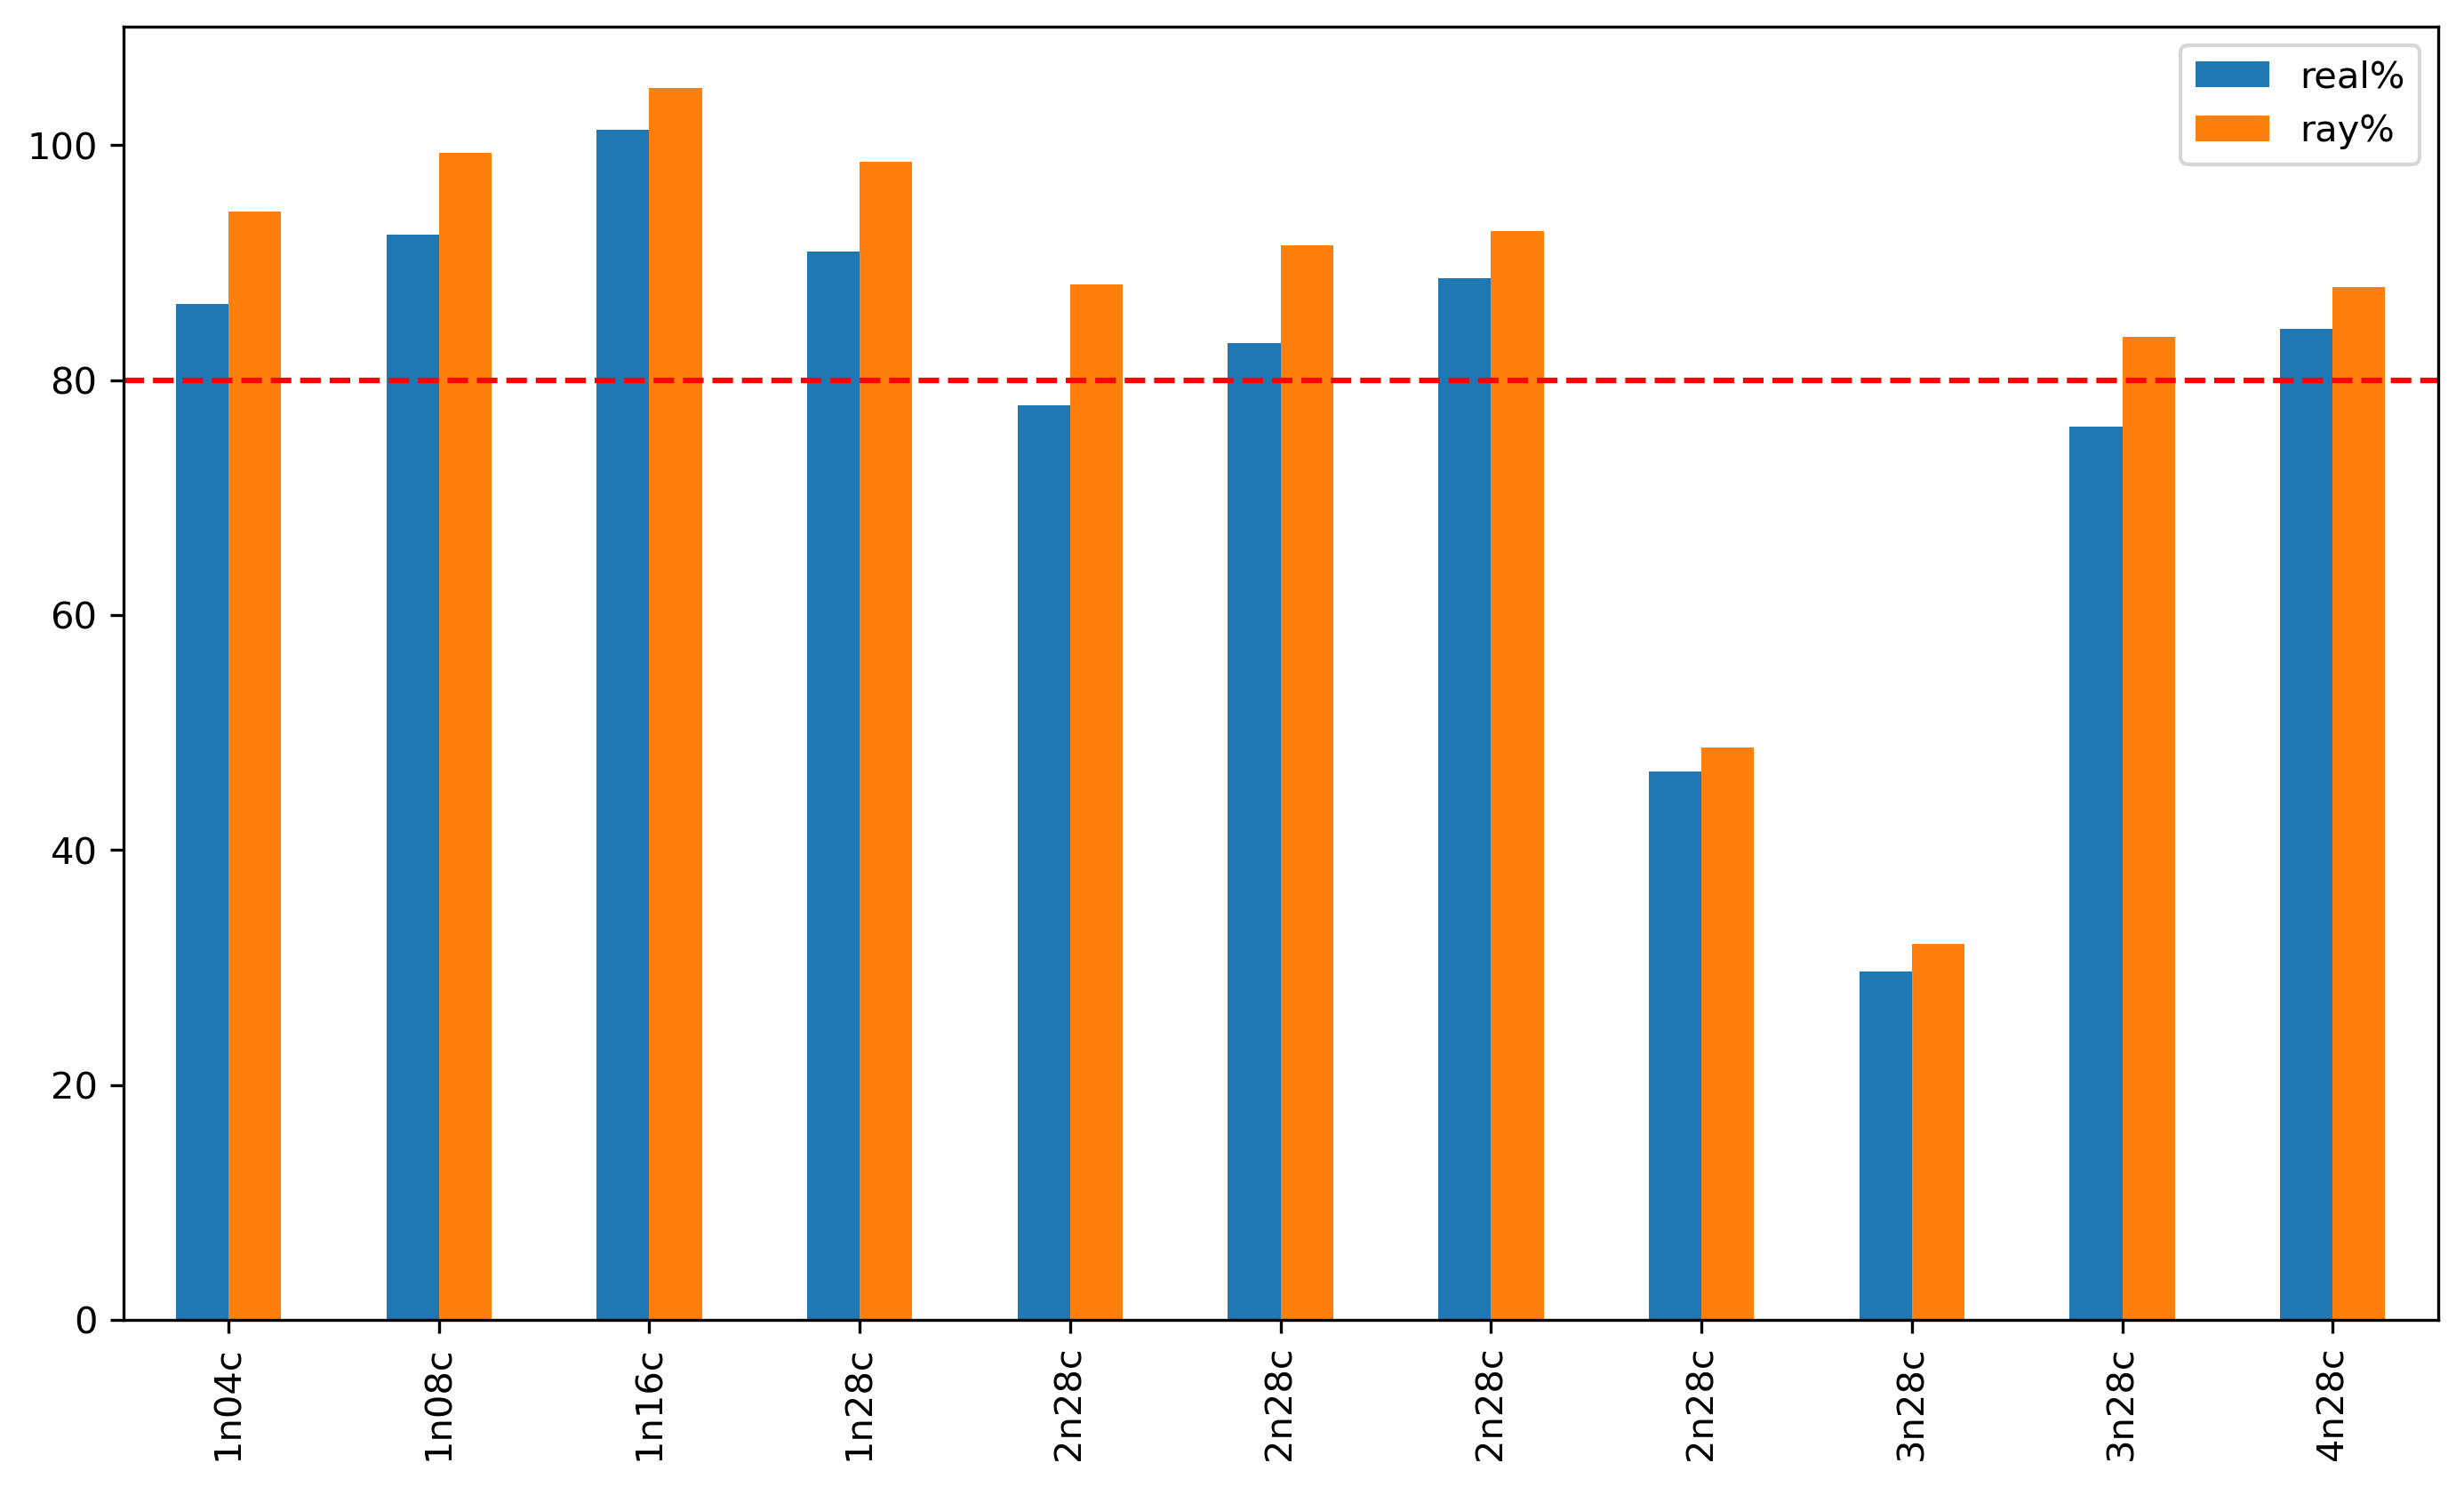

In [5]:
from matplotlib import pyplot as plt

df2plot = df[df.columns[-2:]]
df2plot.index = df["key"]
df2plot = df2plot.sort_index()

x = 0.7
fig = plt.figure(dpi=300, figsize=(16 * x, 9 * x))
ax = fig.add_subplot(1, 1, 1)
assert isinstance(df2plot, pd.DataFrame)
df2plot.plot(kind="bar", ax=ax)
ax.set_xlabel("")
plt.axhline(80, color="r", linestyle="--")

(0.0, 85.0)

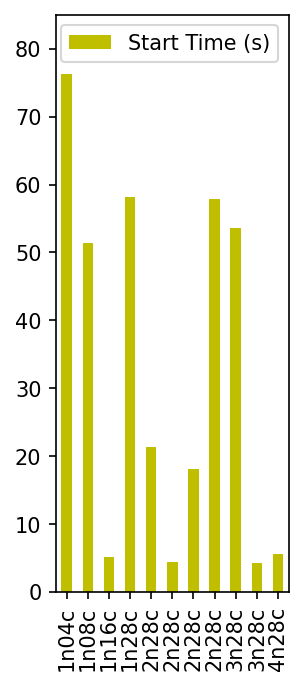

In [6]:
# plt.rcParams["font.sans-serif"] = ["Microsoft YaHei"]  # 设置字体为黑体
# plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题

fig = plt.figure(dpi=150, figsize=(2, 5))
ax = fig.add_subplot(1, 1, 1)
df2plot = pd.DataFrame()
df2plot["Start Time (s)"] = df["took_once_1st"]
df2plot.index = df["key"]
df2plot = df2plot.sort_index()
df2plot.plot(kind="bar", ax=ax, color="y")
ax.set_xlabel("")
ax.set_ylim(0, 85)
# ax.set_title("启动时间(Ray)")

(0.0, 8250.0)

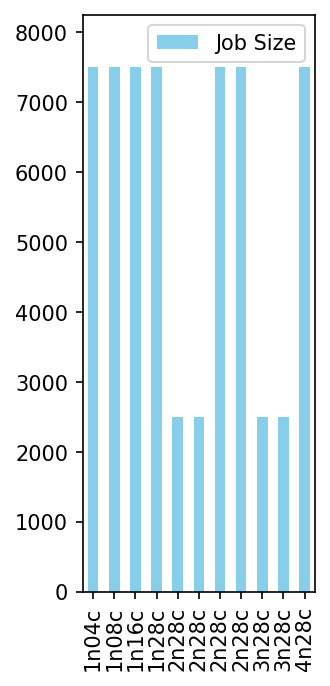

In [7]:
fig = plt.figure(dpi=150, figsize=(2, 5))
ax = fig.add_subplot(1, 1, 1)
df2plot = pd.DataFrame()
df2plot["Job Size"] = df["batch-per-cpu"]
df2plot.index = df["key"]
df2plot = df2plot.sort_index()
df2plot.plot(kind="bar", ax=ax, color="skyblue")
ax.set_xlabel("")
ax.set_ylim(0, 8250)